# STEP 1 : IMPORTING REQUIRED LIBRARIES
Importing the required libraries and checking the availability of GPU.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import cv2
import os
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
tf.random.set_seed(42)
np.random.seed(42)

Num GPUs Available:  1
GPU memory growth enabled


# STEP 2 : DOWNLOADING DATASET
We will download the dataset from 4 sources to give the model the best chance to train on a diverse data to avoid overfitting.

In [2]:
!pip install -q kaggle
from google.colab import files
import os
import shutil
print("Please upload your kaggle.json file...")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nkaggle.json configured successfully.")
    DATA_DIR = 'all_datasets'
    if os.path.exists(DATA_DIR):
        shutil.rmtree(DATA_DIR)
    os.makedirs(DATA_DIR)
    print(f"Created main directory: {DATA_DIR}")

    print("\n[1/4] Downloading dataset 1 (ahmedhamada0)...")
    !kaggle datasets download -d ahmedhamada0/brain-tumor-detection -q
    !unzip -q brain-tumor-detection.zip
    !mkdir -p {DATA_DIR}/dataset1_original
    !mv yes {DATA_DIR}/dataset1_original/yes
    !mv no {DATA_DIR}/dataset1_original/no
    print("      -> Organized.")
    print("\n[2/4] Downloading dataset 2 (navoneel)...")
    !kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -q
    !unzip -q brain-mri-images-for-brain-tumor-detection.zip
    !mkdir -p {DATA_DIR}/dataset2_navoneel
    !mv brain_tumor_dataset/yes {DATA_DIR}/dataset2_navoneel/yes
    !mv brain_tumor_dataset/no {DATA_DIR}/dataset2_navoneel/no
    print("      -> Organized.")
    print("\n[3/4] Downloading dataset 3 (masoudnickparvar)...")
    !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -q
    !unzip -q brain-tumor-mri-dataset.zip -d {DATA_DIR}/temp_masoud
    !mkdir -p {DATA_DIR}/dataset3_masoud
    !mv {DATA_DIR}/temp_masoud/Training {DATA_DIR}/dataset3_masoud/Training
    print("      -> Organized.")
    print("\n[4/4] Downloading balancing dataset (tombackert)...")
    !kaggle datasets download -d tombackert/brain-tumor-mri-data -q
    !unzip -q brain-tumor-mri-data.zip -d {DATA_DIR}/temp_backert

    source_path_healthy = None
    temp_backert_dir = os.path.join(DATA_DIR, 'temp_backert')

    for root, dirs, files in os.walk(temp_backert_dir):
        if 'notumor' in dirs:
            source_path_healthy = os.path.join(root, 'notumor')
            break
    dest_path_healthy = os.path.join(DATA_DIR, 'dataset4_healthy_brains', 'no')
    os.makedirs(dest_path_healthy, exist_ok=True)
    if source_path_healthy:
        print(f"Found 'notumor' folder at: {source_path_healthy}")
        files_to_move = os.listdir(source_path_healthy)
        for filename in files_to_move:
            shutil.move(os.path.join(source_path_healthy, filename), dest_path_healthy)
        print(f" Successfully moved {len(files_to_move)} healthy brain images to '{dest_path_healthy}'")
    else:
        print("FATAL ERROR: Could not find the 'notumor' directory in the unzipped Backert dataset.")
    print("\nCleaning up temporary files...")
    !rm *.zip
    !rm -rf Br35H-Mask-RCNN pred brain_tumor_dataset {DATA_DIR}/temp_masoud {DATA_DIR}/temp_backert
    print("Cleanup complete.")
    print("\nAll datasets downloaded and organized.")
else:
    print("\nkaggle.json not uploaded. Please upload it to ")

Please upload your kaggle.json file...


Saving kaggle.json to kaggle.json

kaggle.json configured successfully.
Created main directory: all_datasets

[1/4] Downloading dataset 1 (ahmedhamada0)...
Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
      -> Organized.

[2/4] Downloading dataset 2 (navoneel)...
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
      -> Organized.

[3/4] Downloading dataset 3 (masoudnickparvar)...
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
      -> Organized.

[4/4] Downloading balancing dataset (tombackert)...
Dataset URL: https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data
License(s): MIT
Found 'notumor' folder at: all_datasets/temp_backert/brain-tumor-mri-dataset/notumor
 Successfully moved 2000 healthy brain images to 'all_datasets/dataset4_healthy_brains/no'

Cleaning up temporary fi

# STEP 3 : DATASET ORGANISATION
It manages all the images and organises them into a common Folder.

In [3]:
# Unify All Four Datasets

import os
import cv2
import numpy as np
print("Preparing dataset 3 (masoudnickparvar)...")
masoud_base_path = 'all_datasets/dataset3_masoud/Training'
masoud_yes_combined_path = os.path.join(masoud_base_path, 'yes_combined')

if not os.path.exists(masoud_yes_combined_path):
    os.makedirs(masoud_yes_combined_path)
    tumor_types = ['glioma', 'meningioma', 'pituitary']
    for tumor_type in tumor_types:
        source_folder = os.path.join(masoud_base_path, tumor_type)
        if os.path.exists(source_folder):
            for filename in os.listdir(source_folder):
                shutil.copy(os.path.join(source_folder, filename), masoud_yes_combined_path)
    print("Tumor types combined.")
else:
    print("Combined 'yes' folder for the third dataset already exists.")

dataset_sources = [
    ('all_datasets/dataset1_original/yes', 'all_datasets/dataset1_original/no'),
    ('all_datasets/dataset2_navoneel/yes', 'all_datasets/dataset2_navoneel/no'),
    (masoud_yes_combined_path, os.path.join(masoud_base_path, 'notumor')),
    ('placeholder', 'all_datasets/dataset4_healthy_brains/no')
]

def create_unified_dataset(sources, destination_dir, force_remake=True):
    dest_yes = os.path.join(destination_dir, 'yes')
    dest_no = os.path.join(destination_dir, 'no')

    if force_remake and os.path.exists(destination_dir):
        print(f"\nRemoving old unified dataset at '{destination_dir}'...")
        shutil.rmtree(destination_dir)

    print(f"Creating new unified dataset at '{destination_dir}'...")
    os.makedirs(dest_yes)
    os.makedirs(dest_no)

    for yes_path, no_path in sources:
        print(f"Processing source: '{os.path.dirname(no_path)}'")

        if yes_path != 'placeholder' and os.path.exists(yes_path):
            for filename in os.listdir(yes_path):
                shutil.copy(os.path.join(yes_path, filename), dest_yes)
        if os.path.exists(no_path):
            for filename in os.listdir(no_path):
                shutil.copy(os.path.join(no_path, filename), dest_no)
        else:
            print(f"Warning: 'no' path not found: {no_path}")

    print("Unified dataset creation process finished.")


#Create the final unified dataset
UNIFIED_DATA_DIR = 'unified_dataset'
create_unified_dataset(dataset_sources, UNIFIED_DATA_DIR)
def load_data_raw(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    yes_dir = os.path.join(data_dir, 'yes')
    no_dir = os.path.join(data_dir, 'no')

    print(f"\nLoading all tumor images from: {yes_dir}")
    for filename in sorted(os.listdir(yes_dir)):
        if filename.lower().endswith(('.png', 'jpg', 'jpeg')):
            img_path = os.path.join(yes_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(1)

    print(f"Loading all non-tumor images from: {no_dir}")
    for filename in sorted(os.listdir(no_dir)):
        if filename.lower().endswith(('.png', 'jpg', 'jpeg')):
            img_path = os.path.join(no_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(0)
    return np.array(images), np.array(labels)
X, y = load_data_raw(UNIFIED_DATA_DIR)
if X is not None and y is not None:
    print(f"\nData loaded successfully from all four sources.")
    print(f"Total images in final dataset: {len(X)}")
    print(f"Total 'Tumor' images: {np.sum(y == 1)}")
    print(f"Total 'No Tumor' images: {np.sum(y == 0)}")
else:
    raise ValueError("Data loading from the unified directory failed. Check previous logs for errors.")

Preparing dataset 3 (masoudnickparvar)...
Tumor types combined.
Creating new unified dataset at 'unified_dataset'...
Processing source: 'all_datasets/dataset1_original'
Processing source: 'all_datasets/dataset2_navoneel'
Processing source: 'all_datasets/dataset3_masoud/Training'
Processing source: 'all_datasets/dataset4_healthy_brains'
Unified dataset creation process finished.

Loading all tumor images from: unified_dataset/yes
Loading all non-tumor images from: unified_dataset/no

Data loaded successfully from all four sources.
Total images in final dataset: 10958
Total 'Tumor' images: 5772
Total 'No Tumor' images: 5186


#  STEP 4 : DATASET VISUALISATION

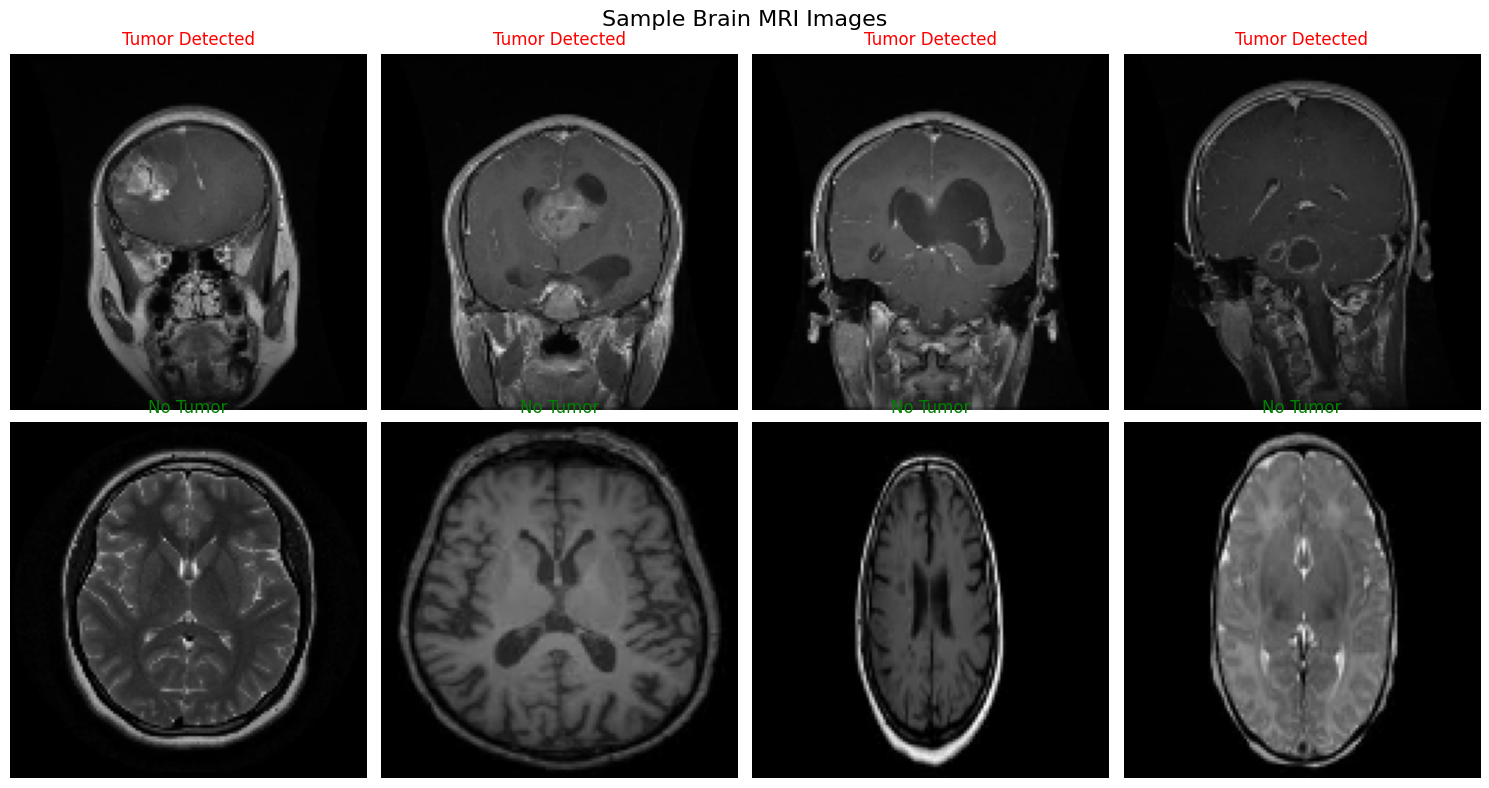

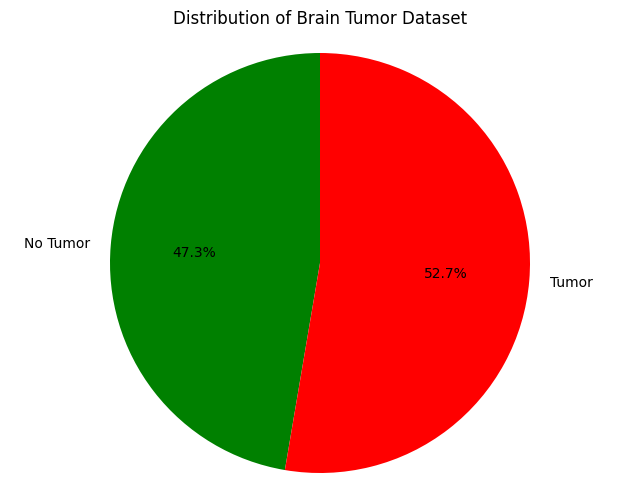

In [4]:
# Data visualization
def visualize_data(X, y, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    fig.suptitle('Sample Brain MRI Images', fontsize=16)

    # Show tumor images
    tumor_indices = np.where(y == 1)[0][:4]
    for i, idx in enumerate(tumor_indices):
        axes[0, i].imshow(X[idx])
        axes[0, i].set_title('Tumor Detected', color='red')
        axes[0, i].axis('off')

    # Show non-tumor images
    no_tumor_indices = np.where(y == 0)[0][:4]
    for i, idx in enumerate(no_tumor_indices):
        axes[1, i].imshow(X[idx])
        axes[1, i].set_title('No Tumor', color='green')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_data(X, y)

# Display dataset statistics
plt.figure(figsize=(8, 6))
labels_count = [np.sum(y == 0), np.sum(y == 1)]
labels_names = ['No Tumor', 'Tumor']
colors = ['green', 'red']

plt.pie(labels_count, labels=labels_names, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Brain Tumor Dataset')
plt.axis('equal')
plt.show()

# STEP 5 : DATA PREPROCESSING
Data preparation and Augmentation

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
#normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

print("\nData generators created successfully.")
print("Normalization and augmentation are now correctly handled.")

Training set size: 7670
Validation set size: 1644
Test set size: 1644

Data generators created successfully.
Normalization and augmentation are now correctly handled.


# STEP 6 : CNN MODEL
Create a model with CNN architecture stacks four blocks of Conv2D, BatchNormalization, and MaxPooling2D to learn features from an image.

In [6]:
# CNN model
# model extracts features
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dropout,
    GlobalAveragePooling2D, Dense
)
from tensorflow.keras.optimizers import Adam

def create_efficient_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
# averages value across the feature map
        GlobalAveragePooling2D(),

        # classifier or fully connectedlayer
        Dense(128, activation='relu'), # 128 neurons for feature combine
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_efficient_cnn_model()

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,873 (1.62 MB)

 Trainable params: 422,657 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

# STEP 7 : USING KERAS TO PREVENT OVERFITTING
 It utilizes EarlyStopping to stop training when validation accuracy ceases to improve.ReduceLROnPlateau is used to dynamically lower the learning rate, and ModelCheckpoint saves the best performing model.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce learning rate
    patience=5,
    min_lr=1e-6,
    verbose=1
)


checkpoint = ModelCheckpoint(
    'best_brain_tumor_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

print("Callbacks defined successfully. Model will be saved to 'best_brain_tumor_model.keras'.")

Callbacks defined successfully. Model will be saved to 'best_brain_tumor_model.keras'.


# STEP 8 : TRAIN THE CNN MODEL


In [8]:
# Train the model

import tensorflow as tf

# Training parameters
epochs = 50
batch_size = 32
# Calculate steps based on the dataset sizes and batch size
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

print(f"Starting training for up to {epochs} epochs...")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

device_name = "GPU" if len(tf.config.list_physical_devices('GPU')) > 0 else "CPU"
print(f"Training on device: {device_name}")


model = create_efficient_cnn_model(input_shape=(128, 128, 3))

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")

Starting training for up to 50 epochs...
Steps per epoch: 239
Validation steps: 51
Training on device: GPU


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6972 - loss: 0.6555
Epoch 1: val_accuracy improved from -inf to 0.47549, saving model to best_brain_tumor_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.6974 - loss: 0.6551 - val_accuracy: 0.4755 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 2/50
  1/239 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8125 - loss: 0.4414

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.47549
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4414 - val_accuracy: 0.4755 - val_loss: 0.7550 - learning_rate: 1.0000e-04
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8161 - loss: 0.4477
Epoch 3: val_accuracy improved from 0.47549 to 0.80821, saving model to best_brain_tumor_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.8161 - loss: 0.4477 - val_accuracy: 0.8082 - val_loss: 0.4146 - learning_rate: 1.0000e-04
Epoch 4/50
  1/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7812 - loss: 0.3747
Epoch 4: val_accuracy improved from 0.80821 to 0.82108, saving model to best_brain_tumor_model.keras
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.3747 - val_accuracy: 0.8211 - val_loss: 0.3942 - learning_rate: 1.0000e-04
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8394 - loss: 0.3915
Epoch 5: val_accuracy improved from 0.82108 t

# VISUALISATION OF ACCURACY AND VALIDATION ACCURACY

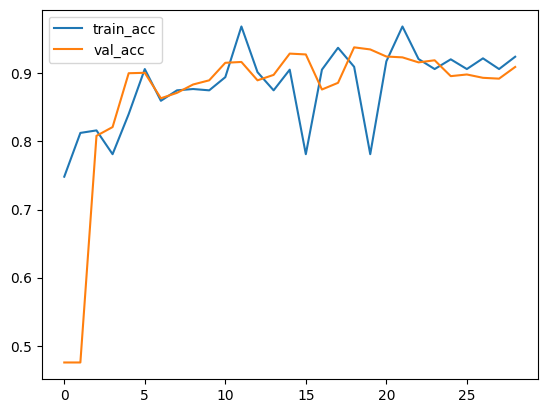

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.show()

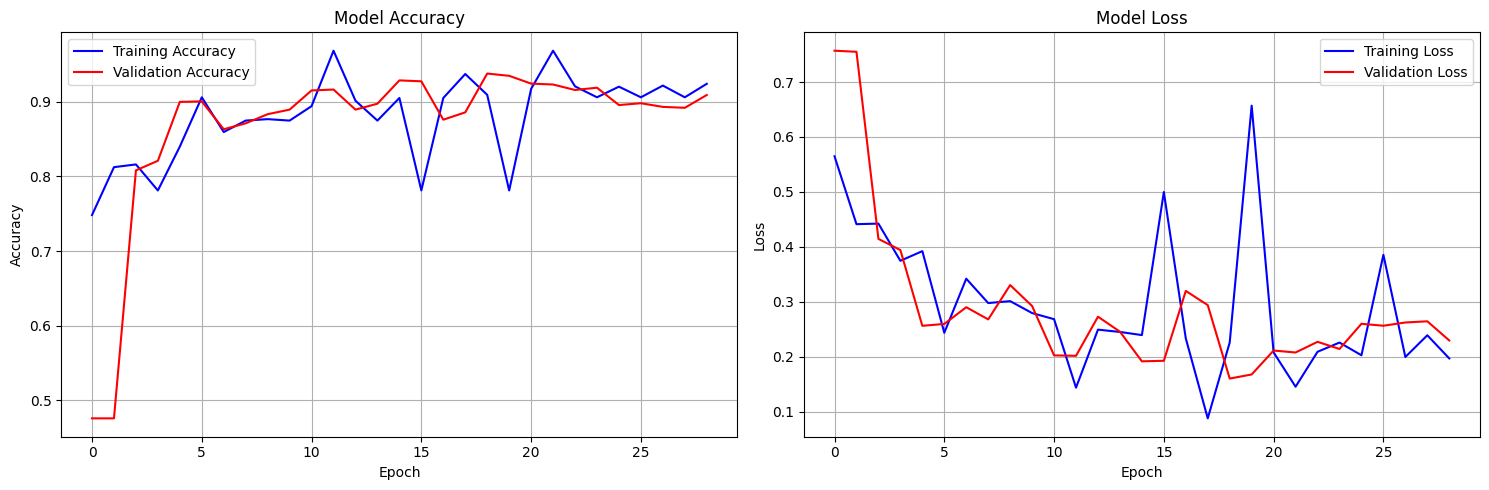

Best validation accuracy: 0.9381


In [10]:
# training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Print best validation accuracy
best_val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy: {best_val_acc:.4f}")

Test Accuracy: 0.7056
Test Loss: 79.0580
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.74      0.58      0.65       778
       Tumor       0.68      0.82      0.75       866

    accuracy                           0.71      1644
   macro avg       0.71      0.70      0.70      1644
weighted avg       0.71      0.71      0.70      1644



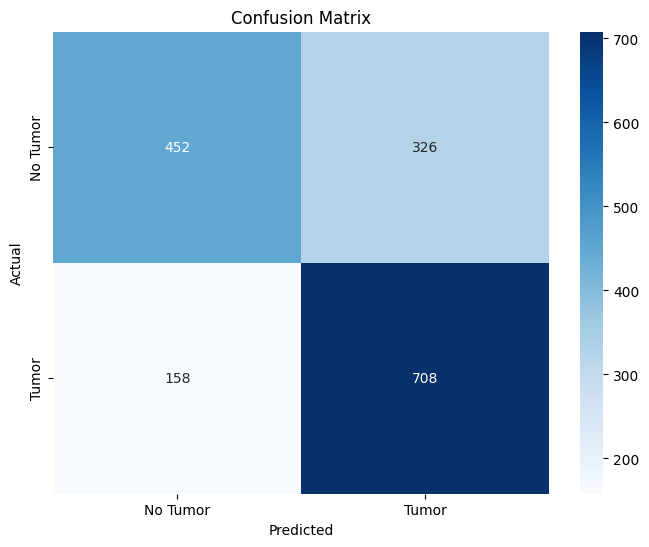


Additional Metrics:
Precision: 0.6847
Recall: 0.8176
F1-Score: 0.7453


In [11]:
best_model = load_model('best_brain_tumor_model.keras')
# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# prediction
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

# Confusion matrixt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [12]:
#  Prediction function
def predict_brain_tumor(image_path, model, img_size=(128, 128), threshold=0.5):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image {image_path}")
            return None, None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, img_size)
        img_normalized = img_resized / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)
        prediction_proba = model.predict(img_batch, verbose=0)[0][0]
        prediction = 1 if prediction_proba > threshold else 0
        confidence = prediction_proba if prediction == 1 else 1 - prediction_proba
        return prediction, confidence, img_rgb

    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None, None, None

def visualize_prediction(image_path, model, threshold=0.5):
    prediction, confidence, img_to_show = predict_brain_tumor(image_path, model, threshold=threshold)

    if prediction is not None:
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_to_show)
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        result_text = "TUMOR DETECTED" if prediction == 1 else "NO TUMOR"
        color = 'red' if prediction == 1 else 'green'
        plt.text(0.5, 0.6, result_text, fontsize=20, fontweight='bold',
                 ha='center', va='center', color=color, transform=plt.gca().transAxes)
        plt.text(0.5, 0.4, f'Confidence: {confidence:.2%}', fontsize=16,
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Failed to make prediction")

print("prediction function created successfully!")


prediction function created successfully!


 Model 'best_brain_tumor_model.keras' loaded successfully!
 Starting Brain Tumor Detection System...
 Brain Tumor Detection System
Please upload a brain MRI image for analysis...
Supported formats: JPG, JPEG, PNG


Saving pi-0008.jpg to pi-0008.jpg

 Processing: pi-0008.jpg
------------------------------


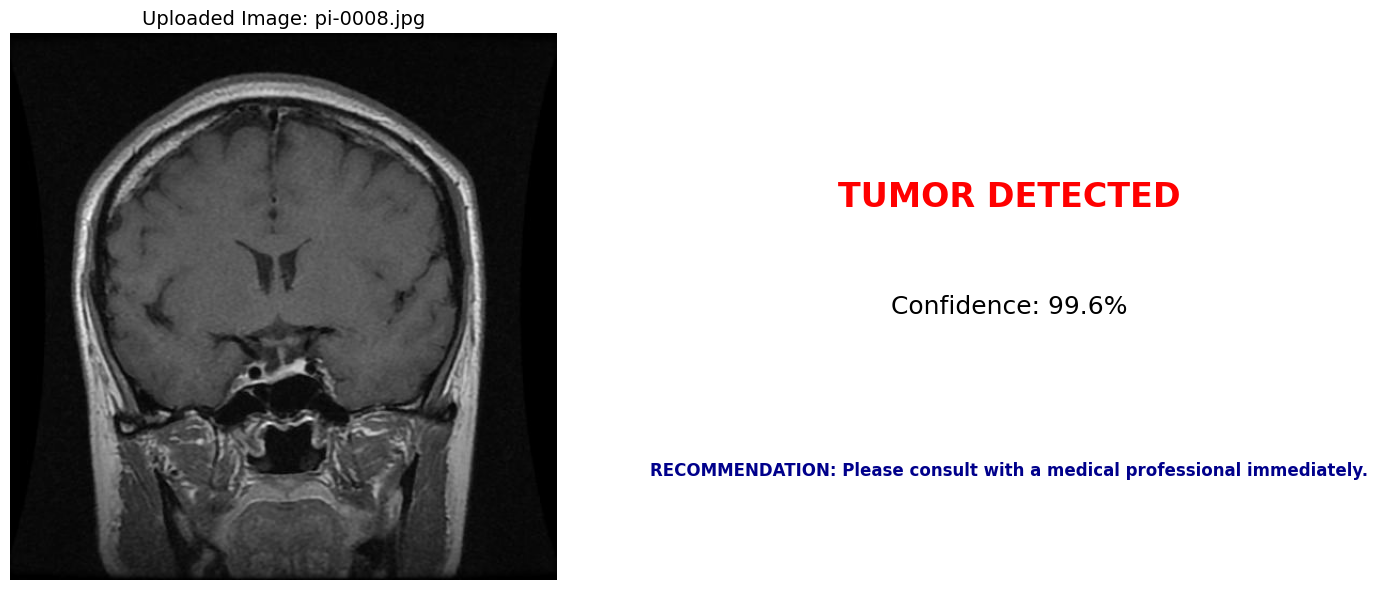

 ANALYSIS RESULTS:
Prediction: Tumor Detected
Raw Confidence Score (Tumor): 0.9963
Decision Threshold: 0.5

 Note: This is an AI model for educational purposes.
Always consult healthcare professionals for medical advice.


In [ ]:
# User image upload and prediction interface
from google.colab import files
from IPython.display import display, HTML, clear_output
import io
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model

try:
    best_brain_tumor_model = load_model('best_brain_tumor_model.keras')
    print(" Model 'best_brain_tumor_model.keras' loaded successfully!")
except Exception as e:
    print(f" Error loading model: {str(e)}")
    print("Please ensure 'best_brain_tumor_model.keras' exists and is accessible.")
    best_brain_tumor_model = None
OPTIMAL_THRESHOLD = 0.5
def upload_and_predict(threshold=OPTIMAL_THRESHOLD):
    if best_brain_tumor_model is None:
        print("\n Cannot proceed: Model was not loaded successfully.")
        return
    print(" Brain Tumor Detection System")
    print("=" * 50)
    print("Please upload a brain MRI image for analysis...")
    print("Supported formats: JPG, JPEG, PNG")
    print("=" * 50)
    uploaded = files.upload()
    if uploaded:
        for filename, file_data in uploaded.items():
            print(f"\n Processing: {filename}")
            print("-" * 30)
            temp_filepath = None
            try:
                nparr = np.frombuffer(file_data, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                if img is None:
                    print("Error: Could not decode the image. Please check the file format.")
                    continue

                # Preprocessing
                original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                processed_img = cv2.resize(original_img, (128, 128))
                processed_img = processed_img / 255.0
                processed_img = np.expand_dims(processed_img, axis=0)
                # Prediction
                # loaded model object
                prediction_proba = best_brain_tumor_model.predict(processed_img, verbose=0)[0][0]
                prediction = 1 if prediction_proba > threshold else 0
                # Visualization
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                ax1.imshow(original_img)
                ax1.set_title(f'Uploaded Image: {filename}', fontsize=14)
                ax1.axis('off')
                ax2.axis('off')
                if prediction == 1:
                    result_text = "TUMOR DETECTED"
                    confidence_text = f"Confidence: {prediction_proba:.1%}"
                    color = 'red'
                    recommendation = "RECOMMENDATION: Please consult with a medical professional immediately."
                else:
                    result_text = " NO TUMOR DETECTED"
                    confidence_text = f"Confidence: {(1 - prediction_proba):.1%}"
                    color = 'green'
                    recommendation = "RECOMMENDATION: No tumor detected, but regular check-ups are still recommended."

                ax2.text(0.5, 0.7, result_text, fontsize=24, fontweight='bold', ha='center', va='center', color=color, transform=ax2.transAxes)
                ax2.text(0.5, 0.5, confidence_text, fontsize=18, ha='center', va='center', color='black', transform=ax2.transAxes)
                ax2.text(0.5, 0.2, recommendation, fontsize=12, fontweight='bold', ha='center', va='center', color='darkblue', transform=ax2.transAxes, wrap=True)

                plt.tight_layout()
                plt.show()

                # Detailed Analysis Results
                print(f" ANALYSIS RESULTS:")
                print(f"Prediction: {'Tumor Detected' if prediction == 1 else 'No Tumor'}")
                print(f"Raw Confidence Score (Tumor): {prediction_proba:.4f}")
                print(f"Decision Threshold: {threshold}")

            except Exception as e:
                print(f" Error processing {filename}: {str(e)}")

    print("\n" + "=" * 50)
    print(" Note: This is an AI model for educational purposes.")
    print("Always consult healthcare professionals for medical advice.")
    print("=" * 50)

def continuous_prediction_interface():
    if best_brain_tumor_model is None:
        print("Cannot start prediction interface as the model failed to load.")
        return
    while True:
        upload_and_predict()
        choice = input("\n Would you like to upload another image? (y/n): ").lower().strip()
        if choice not in ['y', 'yes']:
            print("\n Thank you for using the Brain Tumor Detection System!")
            break
        clear_output(wait=True)
print(" Starting Brain Tumor Detection System...")
continuous_prediction_interface()